Q1

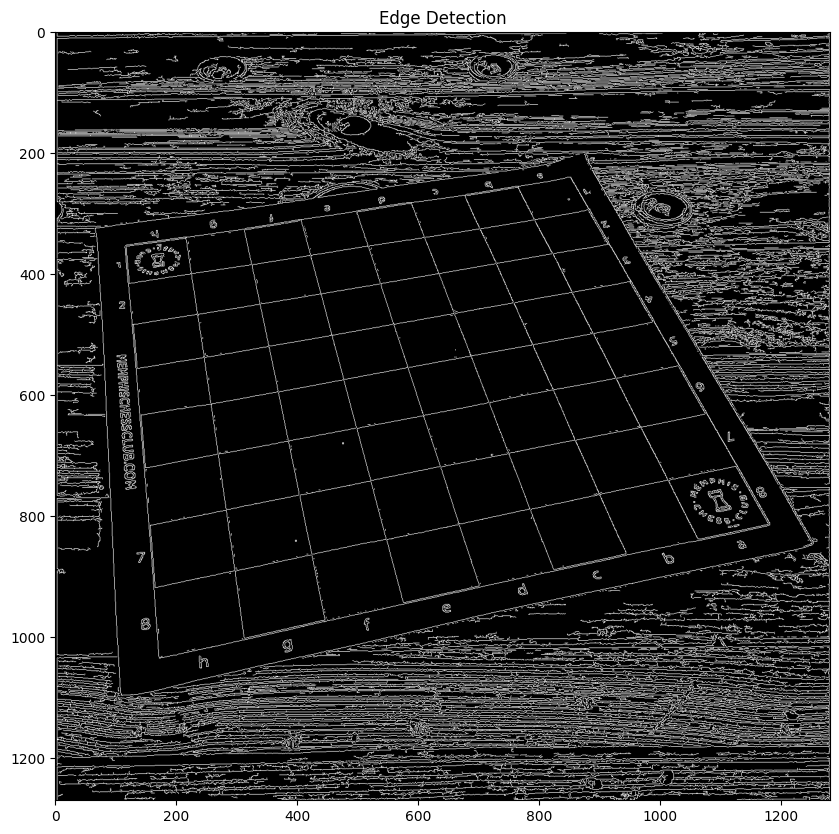

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'chess.jpg'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

edges = cv2.Canny(img, 50, 150)

plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.show()

Now from scratch

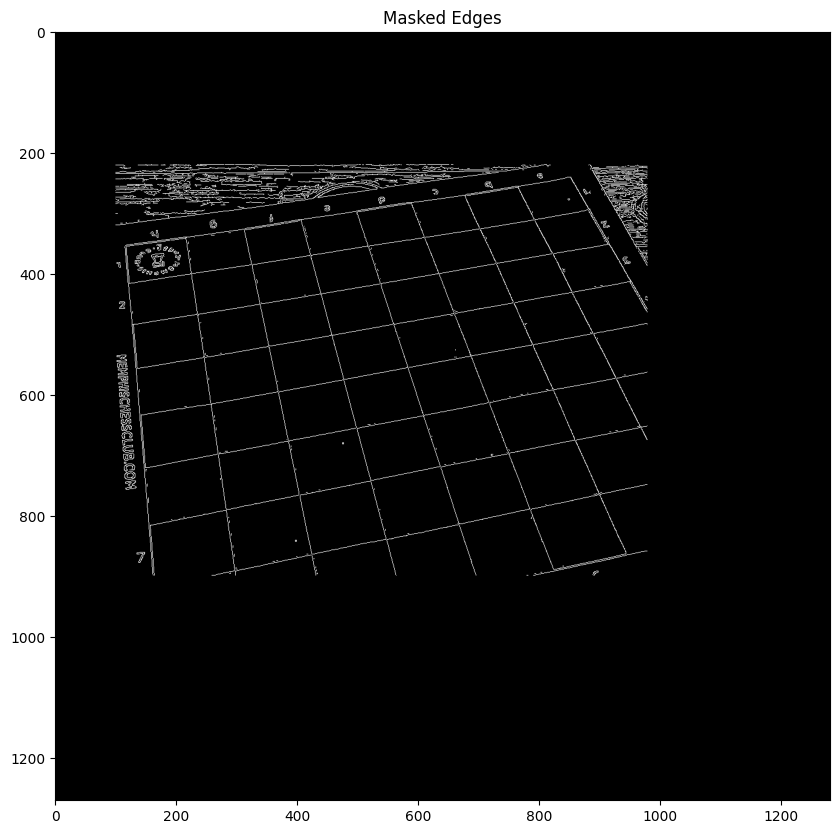

In [53]:
mask = np.zeros_like(edges)
mask[220:900, 100:980] = 255  

masked_edges = cv2.bitwise_and(edges, mask)

plt.figure(figsize=(10, 10))
plt.imshow(masked_edges, cmap='gray')
plt.title('Masked Edges')
plt.show()

In [54]:
def hough_transform(edges):
    rows, cols = edges.shape
    diag_len = int(np.sqrt(rows**2 + cols**2))
    rhos = np.linspace(-diag_len, diag_len, 2*diag_len)
    thetas = np.deg2rad(np.arange(-90, 90))
    
    accumulator = np.zeros((2 * diag_len, len(thetas)))
    y_idxs, x_idxs = np.nonzero(edges)
    
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        
        for theta_idx in range(len(thetas)):
            rho = int(x * np.cos(thetas[theta_idx]) + y * np.sin(thetas[theta_idx]) + diag_len)
            accumulator[rho, theta_idx] += 1
            
    return accumulator, thetas, rhos


In [55]:
def find_peaks(accumulator, num_peaks, threshold=0, min_distance=60):
    indices = np.argwhere(accumulator > threshold)
    sorted_indices = sorted(indices, key=lambda x: accumulator[x[0], x[1]], reverse=True)
    peaks = []
    
    for idx in sorted_indices:
        if len(peaks) >= num_peaks:
            break
        if all(np.linalg.norm(idx - peak) > min_distance for peak in peaks):
            peaks.append(idx)
    
    return peaks

def draw_lines(img, peaks, rhos, thetas):
    for peak in peaks:
        rho = rhos[peak[0]]
        theta = thetas[peak[1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

In [56]:
accumulator, thetas, rhos = hough_transform(masked_edges)

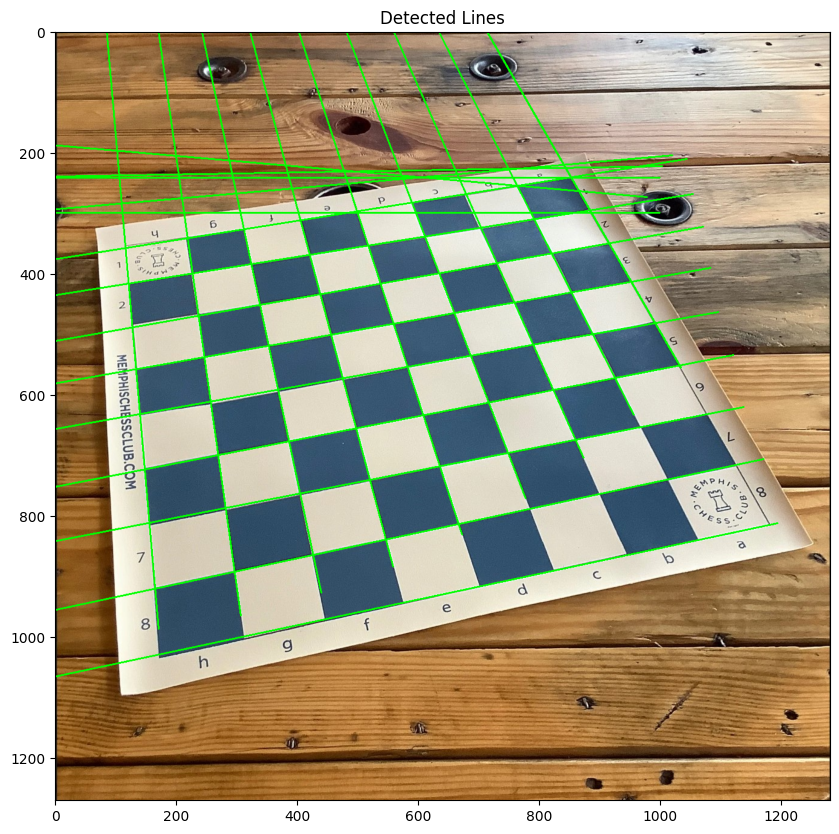

In [57]:
peaks = find_peaks(accumulator, num_peaks=50, threshold=100, min_distance=50)

img_color = cv2.imread(image_path)
draw_lines(img_color, peaks, rhos, thetas)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines')
plt.show()

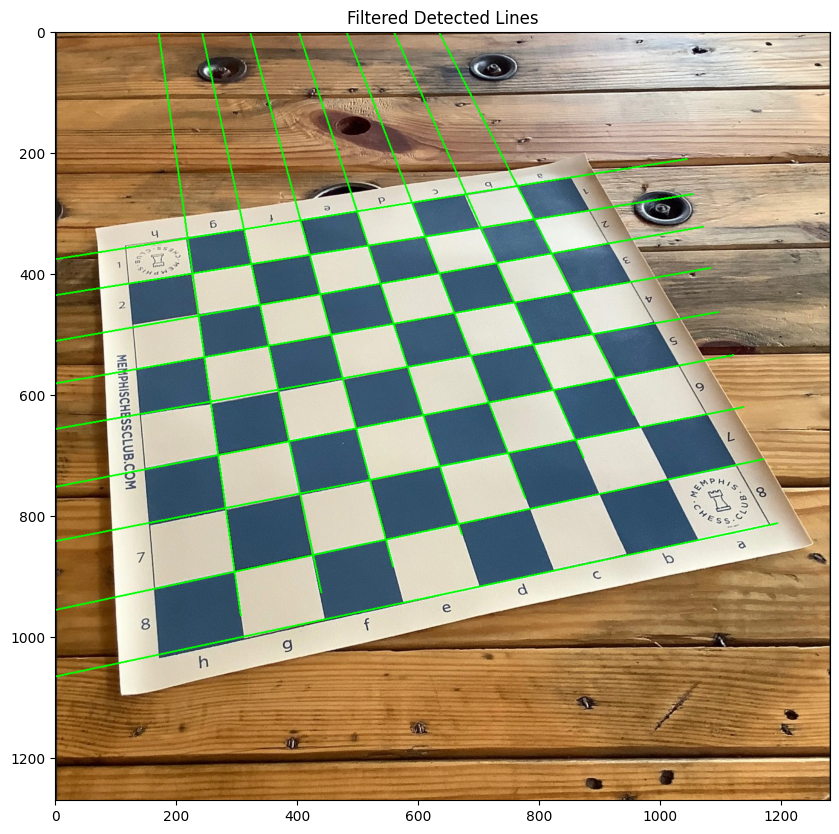

In [58]:
def filter_lines(peaks, rhos, thetas):
    vertical_lines = []
    horizontal_lines = []
    
    for peak in peaks:
        theta = thetas[peak[1]]
        if np.deg2rad(-30) < theta < np.deg2rad(-5) :
            vertical_lines.append(peak)
        elif np.deg2rad(50) < theta < np.deg2rad(85):
            horizontal_lines.append(peak)
    
    return vertical_lines, horizontal_lines

vertical_lines, horizontal_lines = filter_lines(peaks, rhos, thetas)

img_color = cv2.imread(image_path)
draw_lines(img_color, vertical_lines, rhos, thetas)
draw_lines(img_color, horizontal_lines, rhos, thetas)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title('Filtered Detected Lines')
plt.show()

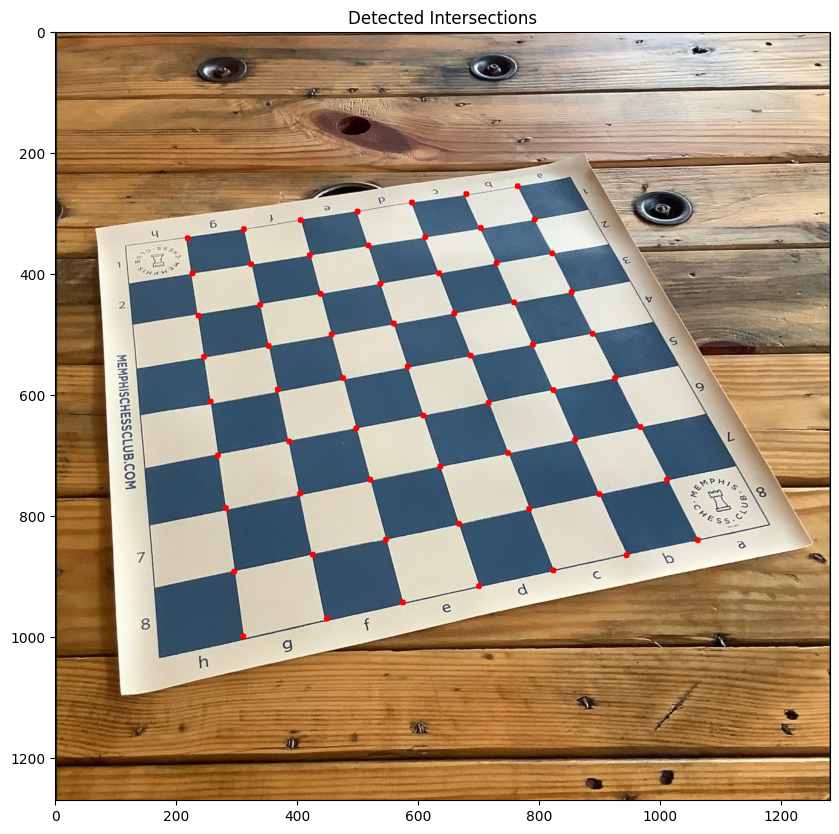

In [59]:
def find_intersections(vertical_lines, horizontal_lines, rhos, thetas):
    intersections = []
    for v_line in vertical_lines:
        rho1 = rhos[v_line[0]]
        theta1 = thetas[v_line[1]]
        for h_line in horizontal_lines:
            rho2 = rhos[h_line[0]]
            theta2 = thetas[h_line[1]]
            A = np.array([[np.cos(theta1), np.sin(theta1)], 
                          [np.cos(theta2), np.sin(theta2)]])
            b = np.array([[rho1], [rho2]])
            if np.linalg.det(A) != 0:
                intersection = np.linalg.solve(A, b)
                intersections.append(intersection)
    return intersections

intersections = find_intersections(vertical_lines, horizontal_lines, rhos, thetas)

img_color = cv2.imread(image_path)
for point in intersections:
    point = tuple(point.flatten().astype(int))
    cv2.circle(img_color, point, 5, (0, 0, 255), -1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title('Detected Intersections')
plt.show()

Q3

I used k=8 because it is aproximatly 8 color in this image

In [64]:
image = cv2.imread("sight.jpg")

rgb_matrix = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pixels = rgb_matrix.reshape(-1, 3)

pixels_normalized = pixels / 255.0

k = 8

np.random.seed(42)
centroids = pixels_normalized[np.random.choice(pixels.shape[0], k, replace=False)]

convergence_threshold = 1e-1
converged = False

while not converged:
   
    distances = np.linalg.norm(pixels_normalized[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

   
    new_centroids = np.array([pixels_normalized[labels == i].mean(axis=0) for i in range(k)])

    if np.linalg.norm(new_centroids - centroids) < convergence_threshold:
        converged = True

    centroids = new_centroids

quantized_pixels = centroids[labels]

quantized_rgb_matrix = (quantized_pixels * 255).astype(np.uint8)
quantized_image = cv2.cvtColor(quantized_rgb_matrix.reshape(rgb_matrix.shape), cv2.COLOR_RGB2BGR)

cv2.imwrite("quantized.jpg", quantized_image)


True

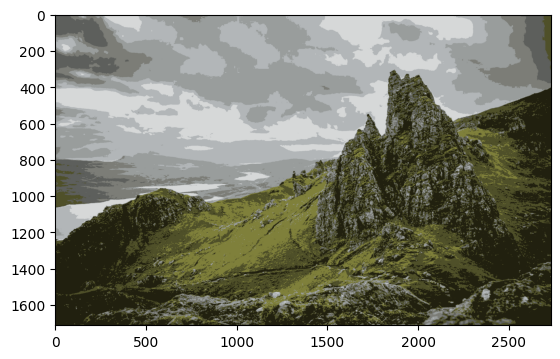

In [66]:
plt.imshow(cv2.cvtColor(quantized_image, cv2.COLOR_BGR2RGB))